#This is a template for tutorial for the GRaM workshop at ICML 2024.

*   Make sure the tutorial is self sustained regards to the code.
*   Write clear comments for readability
*   Usage of any library is allowed.
*   Cite relevant papers and code blocks used.
*   Add any many sections as required.
*   Add visualizations wherever necessary.
*   For ease of reproducibility, save checkpoints from training and load them in the next code block for evaluation.
*   There is no minimum/maximum length of a tutorial.
Checkout these excellent [tutorials](https://uvadlc-notebooks.readthedocs.io/en/latest/) for reference.






PLEASE DO NOT EDIT THIS CELL.


#PHATE Representations Can Effectively Capture Continuous Population Structure in Human Genomic Data
Population Genetics, Manifold Learning, Data Visualization




# Intoduction




Understanding the structure of human genetic variation can have profound effects on fields ranging from medicine to anthropology.

We propose using PHATE (Potential of Heat-diffusion for Affinity-based Transition Embedding) [<a href="#phate">1</a>] to visualize the structure of human genetic variation. Understanding such structure is important. For example, such structure is a known confounder of genome-wide association studies. Towards this goal, researchers have collected large reference datasets of human genetic sequences from all over the world. In this tutorial, we will explore the visualization and exploration of one such dataset: the thousand genomes project.

Typically, such data is studied using Principal Components Analysis (PCA), and recently, t-distributed Stochastic Neighbour Embedding (t-SNE) [<a href="#tsne">2</a>] and Uniform Manifold Approximation and Projection (UMAP) [<a href="#mcinnes2018umap">7</a>]. Here, we show that PHATE can also be used to study the variation that exists within and between populations, and unlike the other methods can simultaneously stratify different populations while also preserving the continuous variation that exists between them.

\\

First, we install some needed packages

In [ ]:
!pip install scprep  # a data preprocessing and plot package: https://scprep.readthedocs.io/en/stable/
!pip install phate   # PHATE python package: https://phate.readthedocs.io/en/stable/
!pip uninstall scikit-learn -y   # uninstall the colab default old version
!pip install -U scikit-learn   # reinstall latest version

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.1/94.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 469.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 602.6/602.6 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 43.7 MB/s eta 0:00:00
Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 47.1 MB/s eta 0:00:00


Next, we import needed packages, and define color palettes that we will use

In [ ]:
import os
import requests
import requests
from io import BytesIO

import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.image as mpimg
from PIL import Image
import pandas as pd
import seaborn as sns
from tabulate import tabulate
import sklearn
import pickle
from typing import Tuple, List
import scprep
import phate
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score


# map populations to superpopulations
super_pops_1000G = {'EAS': ['JPT', 'CHB', 'CHS', 'CDX', 'KHV'],
                    'EUR': ['CEUGBR', 'TSI', 'FIN', 'IBS'],
                    'AFR': ['YRI', 'LWK', 'GWD', 'MSL', 'ESN', 'ACB', 'ASW'],
                    'AMR': ['PUR', 'CLM', 'PEL', 'MXL'],
                    'SAS': ['PJL', 'BEB', 'GIH', 'STUITU']}

# define color pallette / mappings
pop_pallette_1000G_coarse = {'EAS': 'blue',
                            'EUR': 'purple',
                            'AMR': 'red',
                            'AFR': 'green',
                            'SAS': 'orange'
                           }
label_order_1000G_fine = ['YRI', 'ESN', 'GWD', 'LWK', 'MSL', 'ACB', 'ASW',
                           'IBS',  'CEUGBR', 'TSI', 'FIN',
                           'PJL', 'BEB', 'GIH', 'STUITU',
                           'CHB', 'CHS', 'CDX', 'KHV', 'JPT',
                           'MXL', 'CLM', 'PEL', 'PUR']
pop_colors=["#C7E9C0","#A1D99B","#74C476","#41AB5D","#238B45","#006D2C","#00441B",
            "#EFBBFF","#D896FF","#BE29EC","#800080",
            "#FEEDDE","#FDBE85","#FD8D3C","#E6550D",
            "#DEEBF7","#9ECAE1","#008080","#0ABAB5","#08519C",
            "#BC544B","#E3242B","#E0115F","#900D09","#7E2811"]

pop_pallette_1000G_fine = {label:color for label,color in zip(label_order_1000G_fine, pop_colors)}

# The Thousand Genomes Project

The thousand genomes project (1000G) was a project meant to sequence populations from across the world to create a comprehensive resource on human genetic variation.

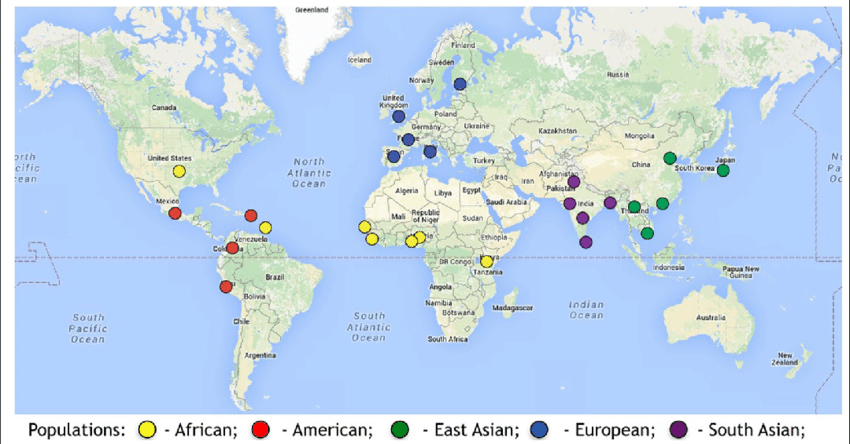


This image shows the geographical distribution of 26 populations in the 1000G. Populations are colored by major continental regions ("superpopulations").
([Image Credit](https://www.internationalgenome.org))

The populations are described in the table below:

|    | Population code | Superpopulation code | Population description                                            |
|----|-----------------|----------------------|-------------------------------------------------------------------|
|  0 | YRI             | AFR                  | Yoruba in Ibadan, Nigeria                                         |
|  1 | ESN             | AFR                  | Esan in Nigeria                                                   |
|  2 | GWD             | AFR                  | Gambian in Western Division, The Gambia - Mandinka                |
|  3 | LWK             | AFR                  | Luhya in Webuye, Kenya                                            |
|  4 | MSL             | AFR                  | Mende in Sierra Leone                                             |
|  5 | ACB             | AFR                  | African Caribbean in Barbados                                     |
|  6 | ASW             | AFR                  | African Ancestry in Southwest US                                  |
|  7 | IBS             | EUR                  | Iberian populations in Spain                                      |
|  8 | CEU             | EUR                  | Utah residents (CEPH) with Northern and Western European ancestry |
|  9 | GBR             | EUR                  | British in England and Scotland                                   |
| 10 | TSI             | EUR                  | Toscani in Italy                                                  |
| 11 | FIN             | EUR                  | Finnish in Finland                                                |
| 12 | PJL             | SAS                  | Punjabi in Lahore, Pakistan                                       |
| 13 | BEB             | SAS                  | Bengali in Bangladesh                                             |
| 14 | GIH             | SAS                  | Gujarati Indians in Houston, TX                                   |
| 15 | STU             | SAS                  | Sri Lankan Tamil in the UK                                        |
| 16 | ITU             | SAS                  | Indian Telugu in the UK                                           |
| 17 | CHB             | EAS                  | Han Chinese in Beijing, China                                     |
| 18 | CHS             | EAS                  | Han Chinese South                                                 |
| 19 | CDX             | EAS                  | Chinese Dai in Xishuangbanna, China                               |
| 20 | KHV             | EAS                  | Kinh in Ho Chi Minh City, Vietnam                                 |
| 21 | JPT             | EAS                  | Japanese in Tokyo, Japan                                          |
| 22 | MXL             | AMR                  | Mexican Ancestry in Los Angeles, California                       |
| 23 | CLM             | AMR                  | Colombian in Medellin, Colombia                                   |
| 24 | PEL             | AMR                  | Peruvian in Lima, Peru                                            |
| 25 | PUR             | AMR                  | Puerto Rican in Puerto Rico                                       |

Where AFR = African, EUR = European, SAS = South Asian, EAS = East Asian, and AMR = Admixed Latin American.

Note that we merged CEU and GBR into a single population, as well as ITU and STU. This was due to their close similarity.



Genotypes were collected from each population. For this project, we fit PCA, t-SNE, and PHATE to the whole-genome sequencing (WGS) 30X release. To limit the genetics markers to a set of good quality and informative polymorphisms, we intersected this dataset positions contained on a largely used genotyping array (Illumina's GSAMD-24v3). This set of positions was then extracted from the 1000G dataset and additional filters were applied, including linkage disequilibrium (LD) pruning. Any missing data was imputed using ShapeIT5.
The data was pre-processed using PCA before being fitted to t-SNE or PHATE.

Following the approach of Diaz-Papovich [<a href="#DiazPapkovich2023">9</a>], We estimated admixture ratios for the AMR populations (plus ASW and ACB) using ADMIXTURE [<a href="#admixture">4</a>]. Here, we assumed the individuals descended from 3 populations, and interpreted these as European, African and Amerindigenous.

Here, we load PCA preprocessed data, labels and estimated admixture ratios from drive.

In [ ]:
def load_from_drive(url):
    # Download the data
    response = requests.get(url)
    data = response.content

    # Load into a DataFrame
    df = pd.read_csv(BytesIO(data))
    df.set_index('Unnamed: 0', inplace=True)
    return df

# Download data and metadata from direct download links
inputs = load_from_drive('https://drive.google.com/uc?export=download&id=1HjK4lGImHr1WKDaz3me8Jj7FJ72S0WzL')
labels = load_from_drive('https://drive.google.com/uc?export=download&id=1egE-5_MaCbTjQeJn6fbogcBjlXAsxSrg')
admix_ratios = load_from_drive('https://drive.google.com/uc?export=download&id=1mYHRCkToVDa2S0cQXKlHzKHDBqb75ozC')

## PCA Visualization of Thousand Genomes: Strengths and Glaring Weaknesses

Principal Component Analysis (PCA) has long been used to visualize and infer population structure using genetic sequence data [<a href="#Patterson2006">5</a>].
When plotting PCA of populations genetic data, we can see a recapitulation of the geographic distances between those populations [<a href="#Novembre2008">6</a>]. You can see a nice (albiet clearly imperfect) visualization of this below:

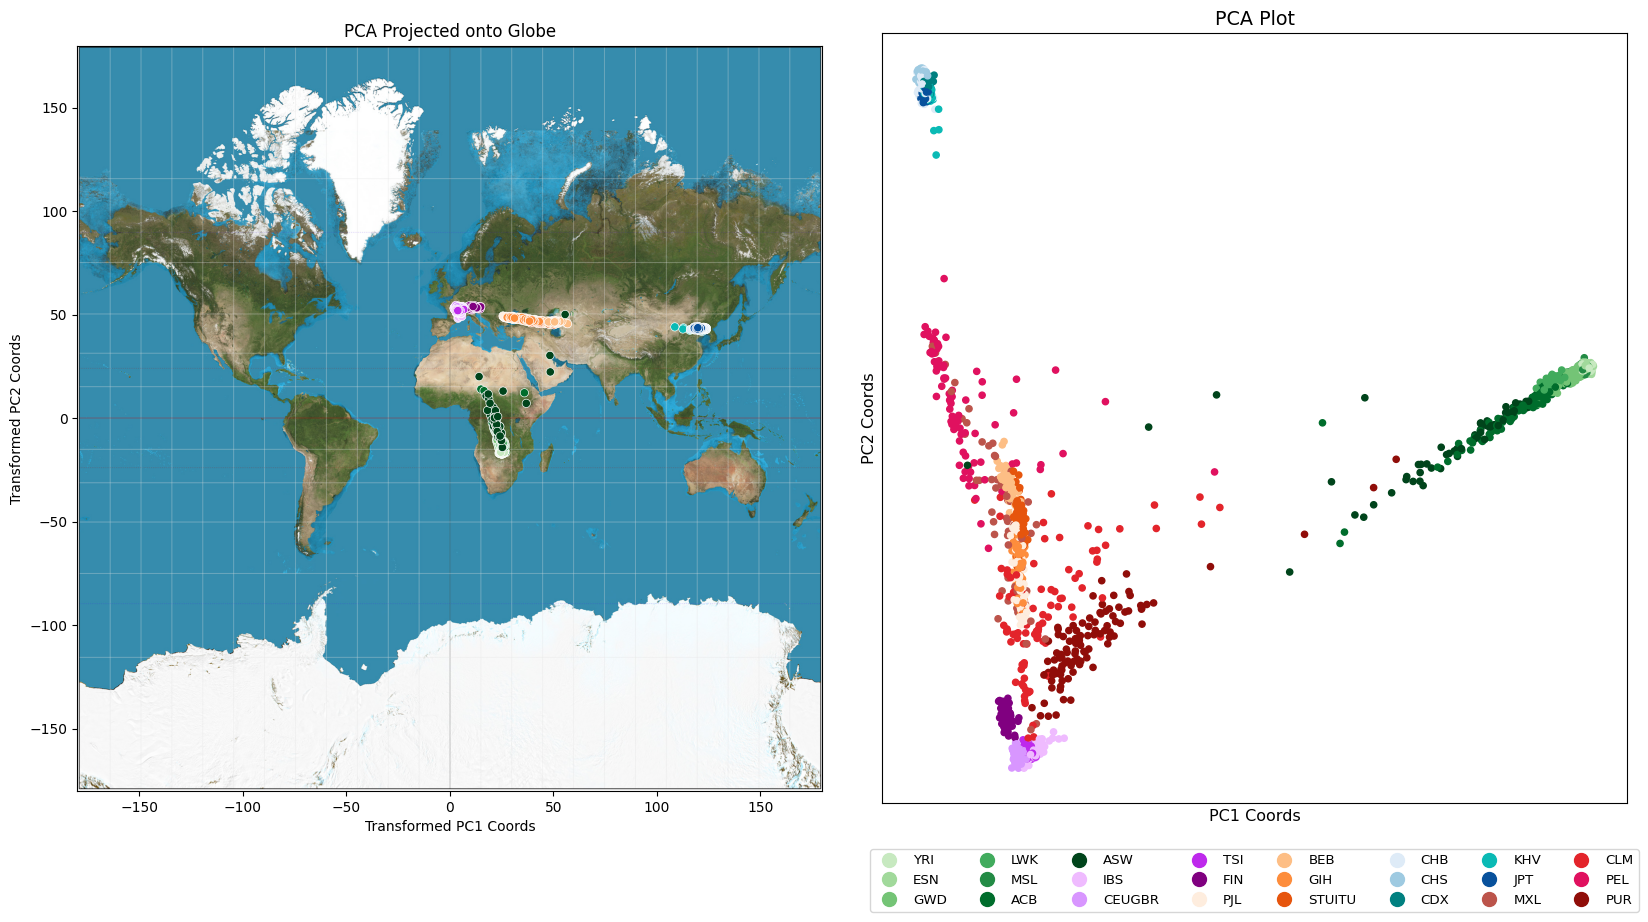

In [ ]:
# Load the map image
response = requests.get('https://drive.google.com/uc?export=download&id=1FFcgc_ed-gDCMGxnh0RYL95cnhNqHFOT')
data = response.content

map_img = Image.open(BytesIO(response.content))

# Create figure and axes
fig, ax = plt.subplots(ncols=2, figsize=(20, 10), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.08})

# Plot the map image
ax[0].imshow(map_img, extent=[-180, 180, -180, 180])

# Don't include AMR since these embeddings wont match geography
idx_to_use = labels['superpopulation']!='AMR'

# build rotation matrix
def rotation_matrix(theta_degrees):
    theta_radians = np.deg2rad(theta_degrees)
    cos_theta = np.cos(theta_radians)
    sin_theta = np.sin(theta_radians)

    rotation_mat = np.array([
        [cos_theta, -sin_theta],
        [sin_theta, cos_theta]
    ])

    return rotation_mat

theta = 110 # Found thru trial and error
rot_matrix = rotation_matrix(theta)
rot_inputs = inputs[['0','1']][idx_to_use]@rot_matrix

# plot PCA Projected onto Globe
sns.scatterplot(x=(rot_inputs[0]+70)/1.5, # found thru trial and error
                y=(rot_inputs[1]+90)/3, # found thru trial and error
                hue=labels['population'][idx_to_use],
                hue_order=label_order_1000G_fine,
                ax=ax[0],
                palette=pop_pallette_1000G_fine)

ax[0].set_title("t-SNE of Thousand Genomes", fontsize=30)
ax[0].set_xlabel('Transformed PC1 Coords')
ax[0].set_ylabel('Transformed PC2 Coords')
ax[0].set_title('PCA Projected onto Globe')
ax[0].get_legend().set_visible(False)

# PCA plot
scprep.plot.scatter2d(inputs, s = 20, cmap = pop_pallette_1000G_fine, ax=ax[1],
                      c = labels['population'], xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PCA Plot',fontsize=8)

ax[1].set_xlabel('PC1 Coords')
ax[1].set_ylabel('PC2 Coords')

plt.show()

Note: in this figure, we removed the AMR populations, since the geographic locations will not align with their genetic distance.

While population structure becomes apparent when displaying pairs of PCs as scatter plots, this approach is ultimately suboptimal. This is because PCA is a linear method and cannot denoise along nonlinear directions.
Furthermore, the first few PCs will only recapitulate the most prominent structure -- one must visualize many PCs to find more subtle structures.

We provide two concrete exampled of structure that is not captured by PCA.

### PCA Visualizations Do Not Capture Discrete, Fine-Grained Population Structure Well

Previous studies identified a small subpopulation within ITU group [<a href="#Sengupta2016">14</a>].
Because the sample size is small relative to the rest, this subpopulation is difficult to see in the PCA, even after looking at 30 PCs!



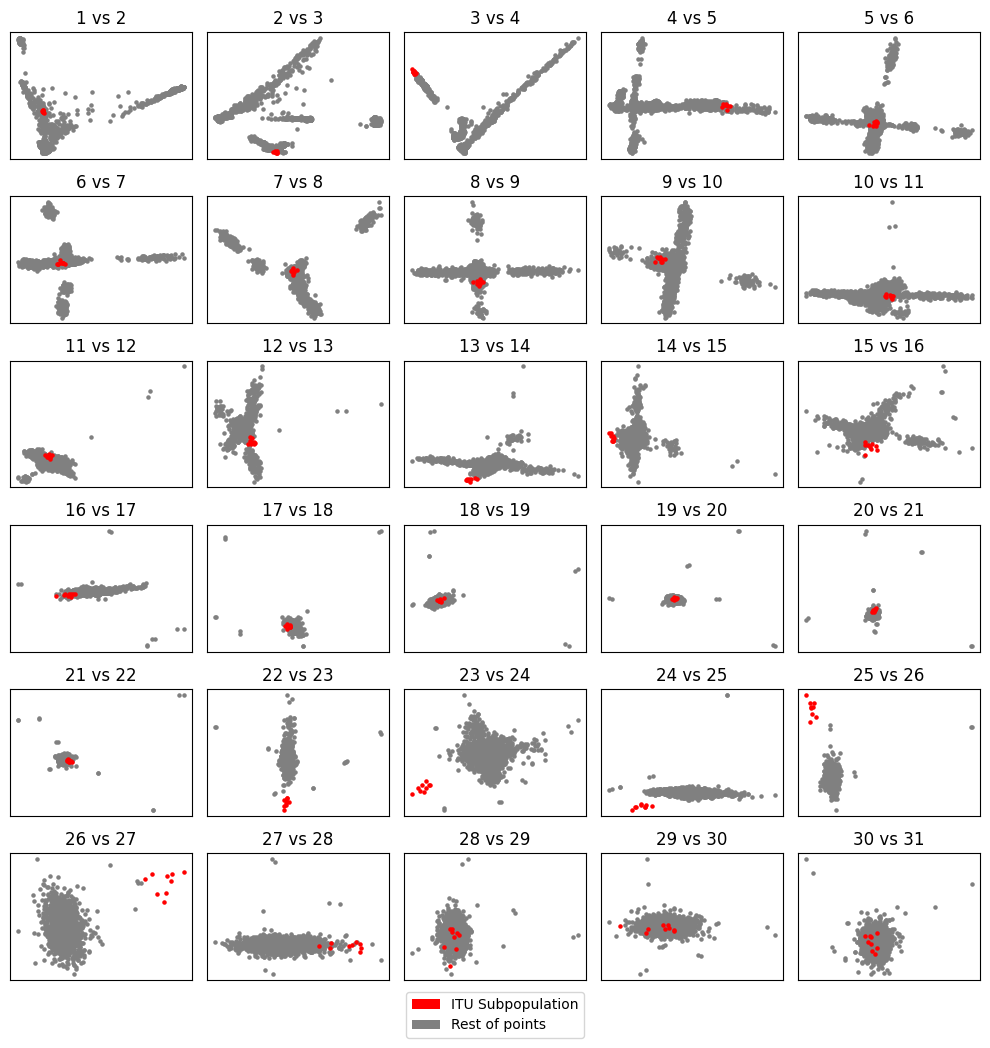

In [ ]:
ITU_subpopulation = ['HG03718', 'HG03772', 'HG03773', 'HG03785', 'HG04017', 'HG04023', 'HG04026', 'HG04054', 'HG04056']
ITU_subpopulation_idxs = inputs.index.isin(ITU_subpopulation)

fig, ax = plt.subplots(nrows=6, ncols=5, figsize=(10, 10))

comp = 1
for i in range(6):
    for j in range(5):
        scprep.plot.scatter2d(inputs[~ITU_subpopulation_idxs][[str(comp-1), str(comp)]], ax=ax[i, j],
                              s=5, color='grey', xticks=False, yticks=False, legend=False)

        scprep.plot.scatter2d(inputs[ITU_subpopulation_idxs][[str(comp-1), str(comp)]], ax=ax[i, j],
                              s=5, color='red', xticks=False, yticks=False, legend=False)

        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        ax[i, j].set_title('{} vs {}'.format(comp, comp+1), fontsize=12)

        comp += 1

legend_elements = [Patch(facecolor='red', label='ITU Subpopulation'),
                   Patch(facecolor='grey', label='Rest of points')]

fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()

### PCA Visualizations Do Not Capture Continuous Admixture Structure Well

As can be seen below, the PC representation cannot clearly distinguish the admixture trajectory structure. The signal appears redundantly across multiple PCs. When the signal is apparent, it appears superimposed with other signals. For example, the admixture cline is clearly visible in PC 1 and 2. However, the visualization wrongly suggests that SAS populations have high European and Amerindigenous admixture levels. This is due to the admixture signal being indistinguishable from the other geographical signal being captured.

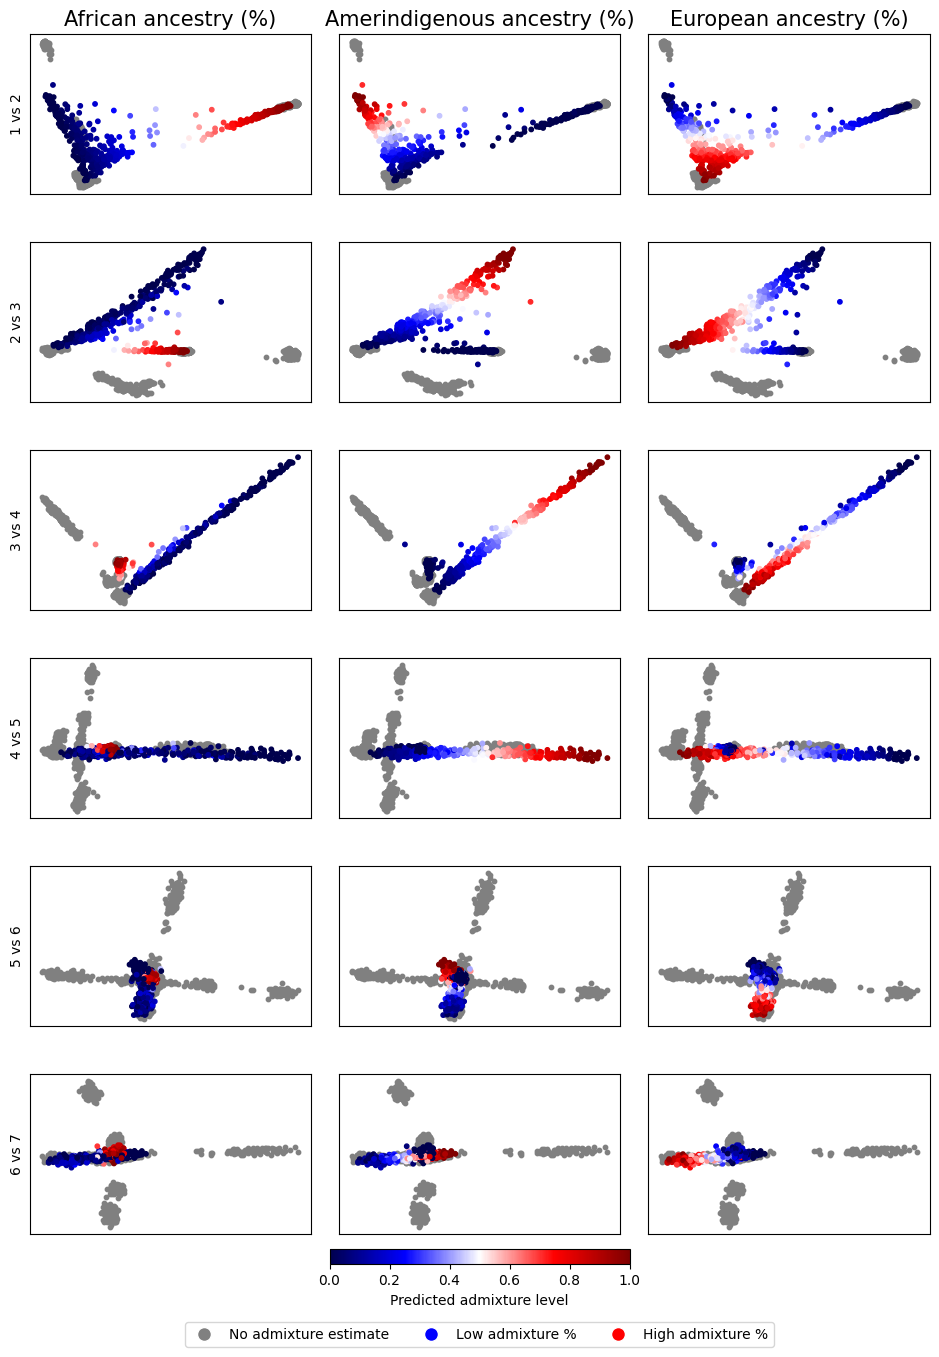

In [ ]:
# plot admixture function
def plot_admixture(embedding, admix_ratios, ax, label_prefix = None):
    for col, score_name in enumerate(admix_ratios.columns):
        has_admixed_estimate = admix_ratios[score_name] > 0

        scatter_no_admix = scprep.plot.scatter2d(embedding[~has_admixed_estimate], s = 10, ax=ax[col],
                                                  color = [0.5, 0.5, 0.5, 1], xticks=False, yticks=False, legend = False,
                                                  label_prefix=label_prefix, fontsize=18)
        scatter_admix = scprep.plot.scatter2d(embedding[has_admixed_estimate], s = 10, ax=ax[col],
                                              c = admix_ratios[score_name][has_admixed_estimate], xticks=False, yticks=False, legend = False,
                                              label_prefix=label_prefix, fontsize=18, cmap = 'seismic')

    # Add custom legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='No admixture estimate'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Low admixture %'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='High admixture %')
    ]

    return scatter_no_admix, scatter_admix, legend_elements

# plot admixture using PCA
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(10, 15), gridspec_kw={'wspace': 0.1})

for row, pc in enumerate([0,1,2,3,4,5]):
    scatter_no_admix, scatter_admix, legend_elements= plot_admixture(inputs[[str(pc), str(pc+1)]].values, admix_ratios, ax[row])
    ax[row, 0].set_ylabel(str(pc+1) + ' vs ' + str(pc+2)) # only first column

for i, score_name in enumerate(admix_ratios.columns):
    ax[0, i].set_title(score_name, fontsize=15)

# Add colorbar
cbar_ax = fig.add_axes([0.35, 0.13, 0.3, 0.01])  # Adjust these values as needed for position and size
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.seismic), cax=cbar_ax, orientation='horizontal', fraction=0.02)
cbar.set_label('Predicted admixture level')

# add legend
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.07), ncol=3)

# Manually adjust the layout
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.15, hspace=0.3, wspace=0.3)

plt.show()

## t-SNE Visualization of Thousand Genomes: Different Strengths and Weaknesses

Recent work proposes using nonlinear dimensionality reduction methods, in particular, t-SNE and UMAP [<a href="#mcinnes2018umap">7</a>] to complement PCA.

These methods prioritize nearest neighbour preservation to produce low dimensional embeddings that resemble detached blobs.
Several works demonstrate that these blobs can correspond to fine-scale population strata [<a href="#DiazPapkovich2020">8</a>, <a href="#DiazPapkovich2023">9</a>, <a href="#Sakaue2020">10</a>].
However, t-SNE and UMAP both tend to focus on local structure preservation at the expense of the global structure.
Thus the size, shape and relative location of these blobs are meaningless [<a href="#Moon2019phate">1</a>, <a href="#wattenberg2016how">11</a>], making these embeddings unable to properly capture the changes in genetic diversity and distances that arise from admixture and long-term migratory patterns.

First, let's compute t-SNE embeddings for the thousand genomes dataset.

In [ ]:
tsne_op = TSNE(n_components=2, perplexity=20, max_iter=1000, random_state=42)
tsne_embedding = tsne_op.fit_transform(inputs.values)

Unfortunately, a t-SNE or UMAP visualization of genetic data can be interpreted in a harmful manner, even when the plot is produced with good intentions.
If the blobs are identified as belonging to different genetic ancestries, the lack of visual relationships between them gives the false impression that there is no connection between the groups.
This issue was further highlighted by the recent controversy surrounding a UMAP plot included in an article presenting the ``All of Us" cohort [<a href="#2024AllofUs">3</a>].

We plot our t-SNE plots beside the infamous UMAP. We can see both suffer from the same representational problems.

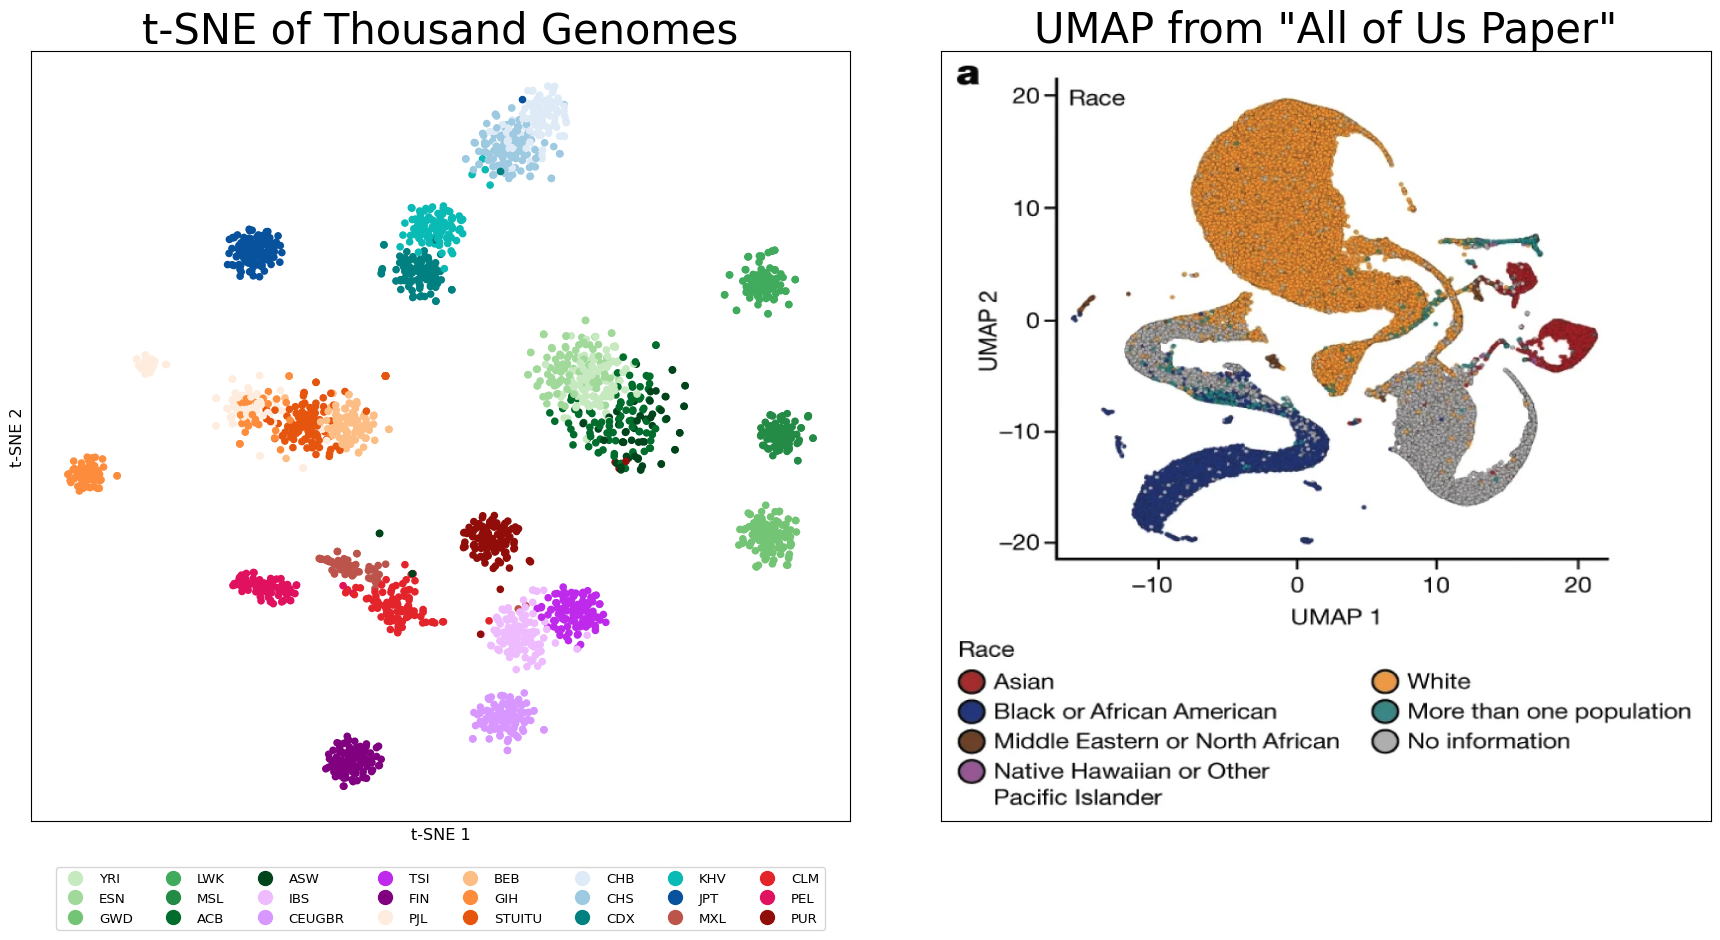

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(22, 10), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.08})

scprep.plot.scatter2d(tsne_embedding, s = 20, cmap = pop_pallette_1000G_fine, ax=ax[0],
                      c = labels['population'], xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      label_prefix="t-SNE ", fontsize=8)
ax[0].set_title("t-SNE of Thousand Genomes", fontsize=30)

# Load the map image
response = requests.get('https://drive.google.com/uc?export=download&id=15yYgnr24DX_uRg-BSJZSPE9wjjN1U4Yy')
data = response.content

umap_img = Image.open(BytesIO(response.content))

# Plot the map image
_ = ax[1].imshow(umap_img, extent=[-180, 180, -180, 180])
_ = ax[1].set_title('UMAP from "All of Us Paper"', fontsize=30)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

plt.show()

### t-SNE Visualizations Do Not Capture Continous Admixture Structure Well

As expected, the t-SNE embeddings do not capture the global admixture structure. The continuous structure is broken up into discrete blobs.

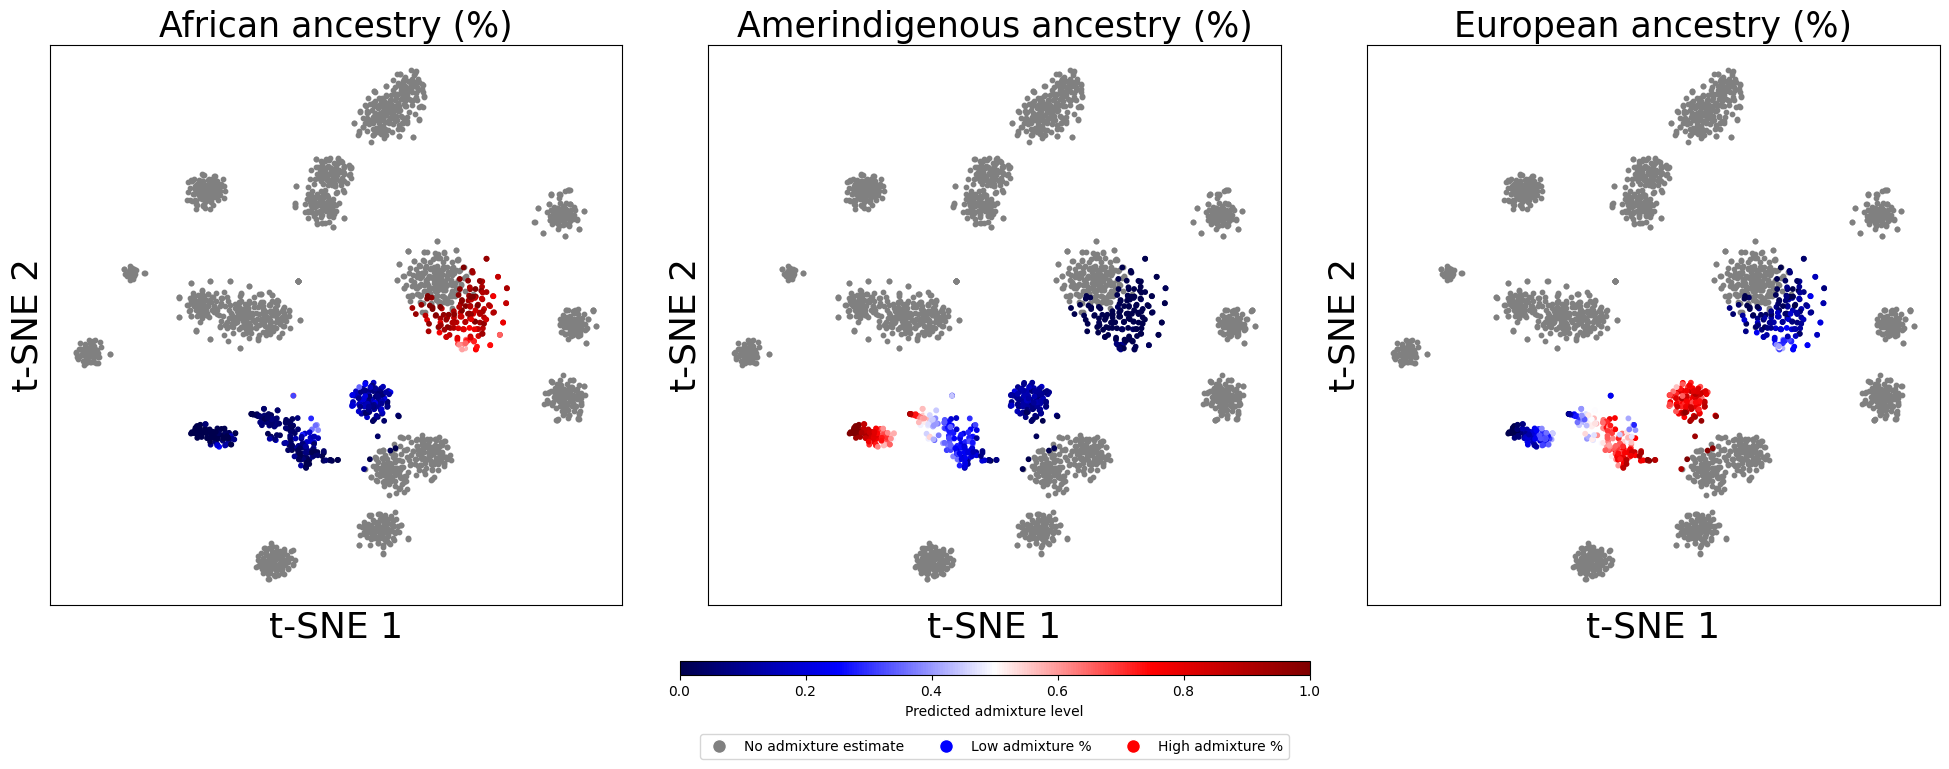

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(21, 7), gridspec_kw={'wspace': 0.15})

scatter_no_admix, scatter_admix, legend_elements = plot_admixture(tsne_embedding, admix_ratios, ax, label_prefix='t-SNE ')

for i, score_name in enumerate(admix_ratios.columns):
    ax[i].set_title(score_name, fontsize=25)

# Add colorbar
cbar_ax = fig.add_axes([0.35, 0.05, 0.3, 0.02])  # Adjust these values as needed for position and size
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.seismic), cax=cbar_ax, orientation='horizontal', fraction=0.02)
cbar.set_label('Predicted admixture level')

# Add custom legend
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.08), ncol=3)

# Manually adjust the layout
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.15, hspace=0.3, wspace=0.3)

plt.show()

# The PHATE Algorithm
PHATE offers a novel approach to dimensionality reduction and data visualization. This method captures both local and global relationships by simulating how heat diffuses over a graph representing the data points and their connections.

The PHATE algorithm can be roughly broken down into 6 steps:

<ol type="a">
  <li>Create the input data matrix (in the context of population genetics, this would be matrix containing each individuals genotype)</li>
  <li>Compute distances between the pairs of points.</li>
  <li>Convert these distances into affinities such that small distances have high affinities and the rest have small affinities. We then row normalize so that we may treat the affinies as transition probabilities of a random walk (in the figure, the red point is most likely to jump to its neighbours -- the yellow points).</li>
  <li>Diffuse this data to denoise it and better learn long-ranged relationships in the data.</li>
  <li>Use the diffused probabilities to construct an informational distance that better captures global structure.</li>
  <li>Finally, use Multi Dimensional Scaling (MDS) to learn a low dimensional representation from the informational distances.</li>
</ol>

A complete description of PHATE can be found in the original publication [<a
href="#phate">1</a>].

In addition, please see the [documentation](https://phate.readthedocs.io/en/stable/index.html) and [tutorials](https://github.com/KrishnaswamyLab/PHATE/tree/main/Python/tutorial).

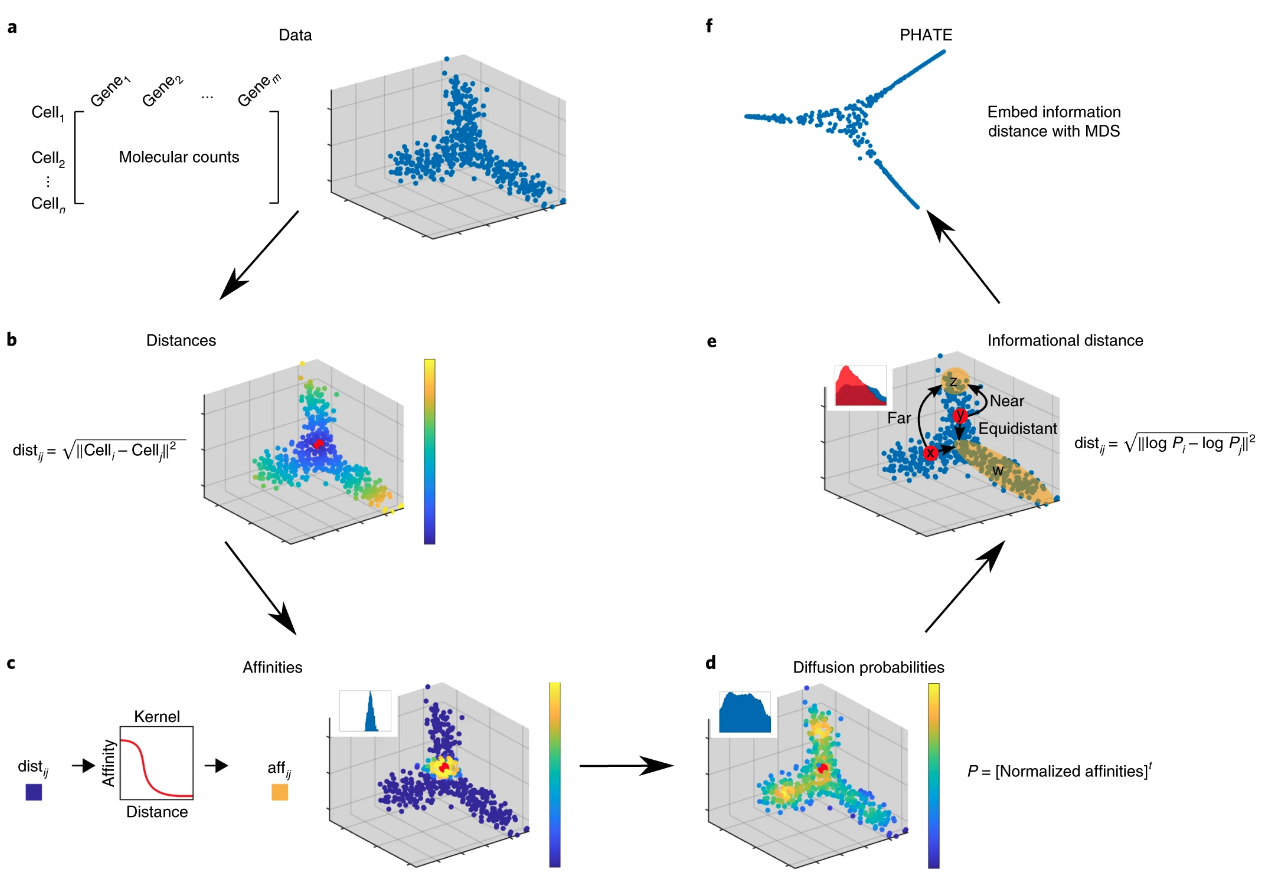

PHATE steps schematic. ([Photo Credit](https://www.nature.com/articles/s41587-019-0336-3/figures/2))

# PHATE Application to Thousand Genomes

We fit PHATE to the thousand genomes dataset.

In [ ]:
# initial 2D phate embedding
random_state = 42
n_components = 2
t = 5
knn = 5
decay = 60
phate_op = phate.PHATE(random_state=random_state,
                       n_components=n_components,
                       knn=knn,
                       n_pca=None,
                       decay=decay,
                       t=t)
phate_op.fit(inputs.values)
phate_embedding = phate_op.transform()


Running PHATE on 2322 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.58 seconds.
  Calculating affinities...
  Calculated affinities in 0.03 seconds.
Calculated graph and diffusion operator in 0.62 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.25 seconds.
  Calculating KMeans...
  Calculated KMeans in 5.98 seconds.
Calculated landmark operator in 7.29 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 1.04 seconds.
Calculating metric MDS...
Calculated metric MDS in 4.69 seconds.


### Comparison of PCA, t-SNE and PHATE visualizations


First, lets compare PCA, t-SNE, and PHATE side-by-side. We notice that PCA seems to be capturing mostly continous structure and t-SNE seems to be capturing mostly discrete (cluster) structure. PHATE seems to be capturing both continuous and discrete structure!

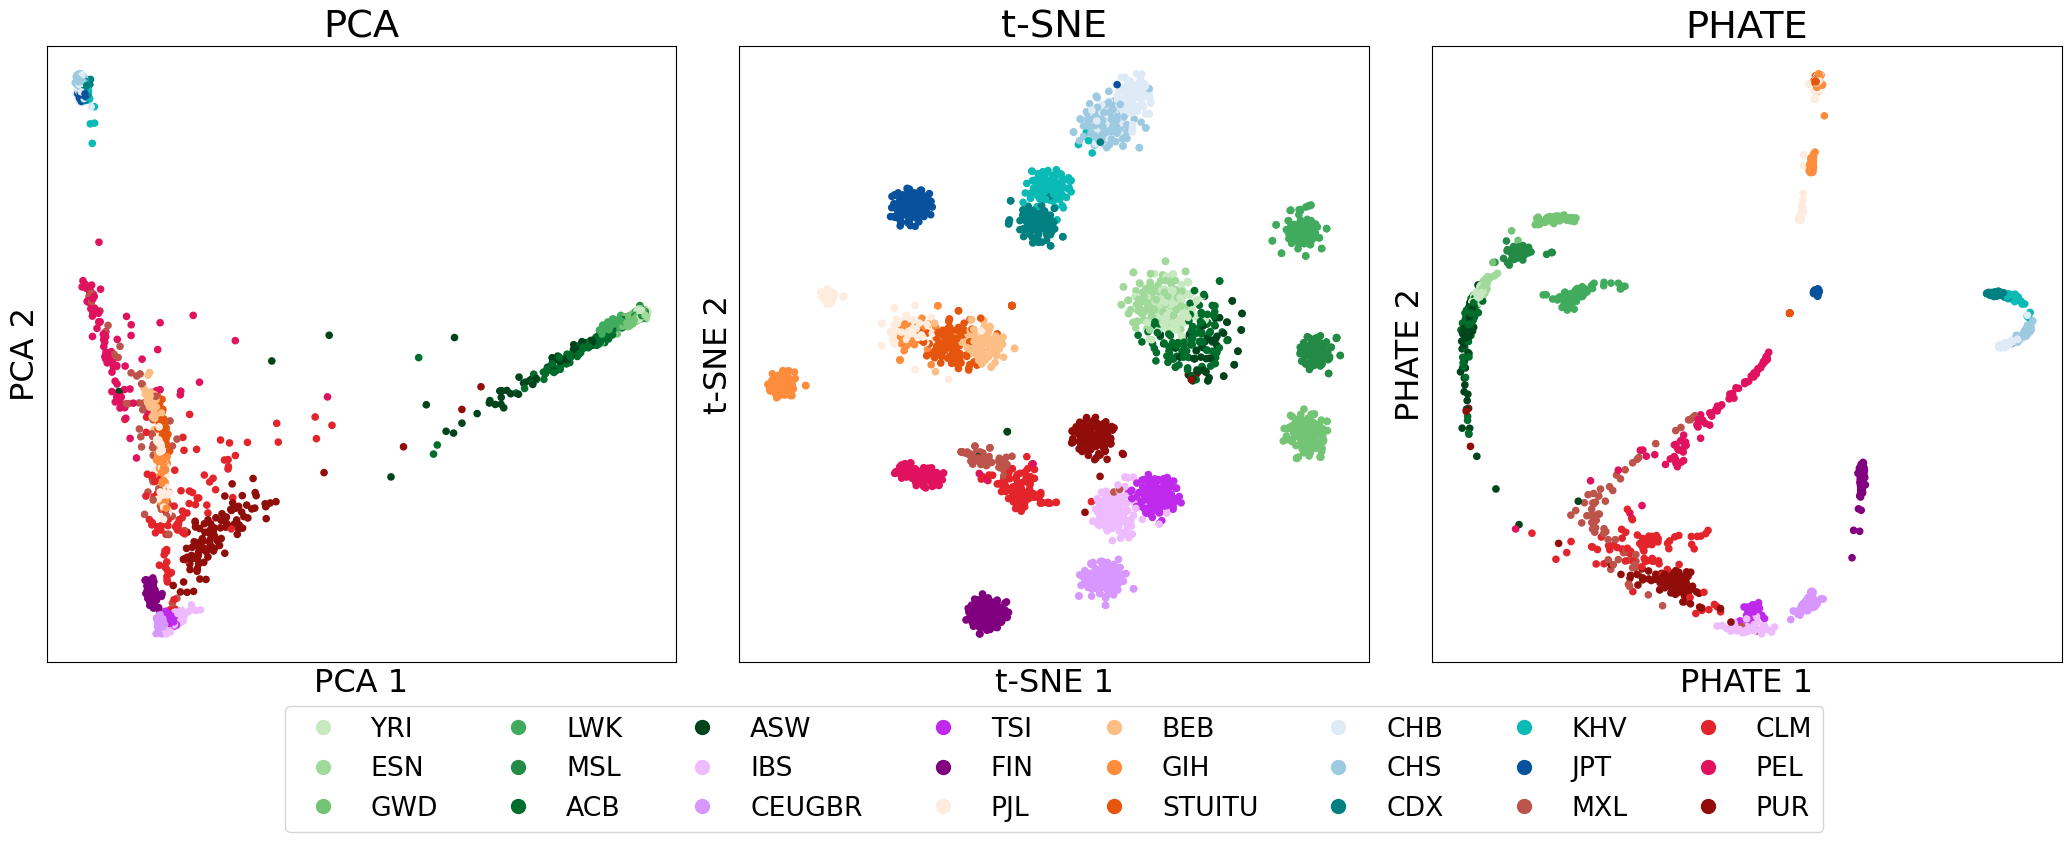

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(26, 8), gridspec_kw={'width_ratios': [1, 1, 1], 'wspace': 0.1})
# PCA
scprep.plot.scatter2d(inputs[['0','1']], s=20, ax=axes[0],
                      cmap=pop_pallette_1000G_fine, c=labels['population'],
                      xticks=False, yticks=False, legend=False,
                      label_prefix="PCA ", title='PCA', fontsize=16)
# t-SNE
scprep.plot.scatter2d(tsne_embedding, s=20, ax=axes[1],
                      cmap=pop_pallette_1000G_fine, c=labels['population'],
                      xticks=False, yticks=False, legend=True,
                      legend_loc='upper center', legend_anchor=(0.5, -0.05), legend_ncol=8,
                      label_prefix="t-SNE ", title='t-SNE', fontsize=16)
# PHATE
scprep.plot.scatter2d(phate_embedding, s=20, ax=axes[2],
                      cmap=pop_pallette_1000G_fine, c=labels['population'],
                      xticks=False, yticks=False, legend=False,
                      label_prefix="PHATE ",title='PHATE', fontsize=16)

plt.show()

## PHATE Visualizations Capture Admixture

We now show that the PHATE embeddings preserve both fine scale population structure and admixture signal.

If we color the PHATE embeddings with the estimated admixture ratios, it becomes clear that the trajectories in the embeddings correspond to admixture.

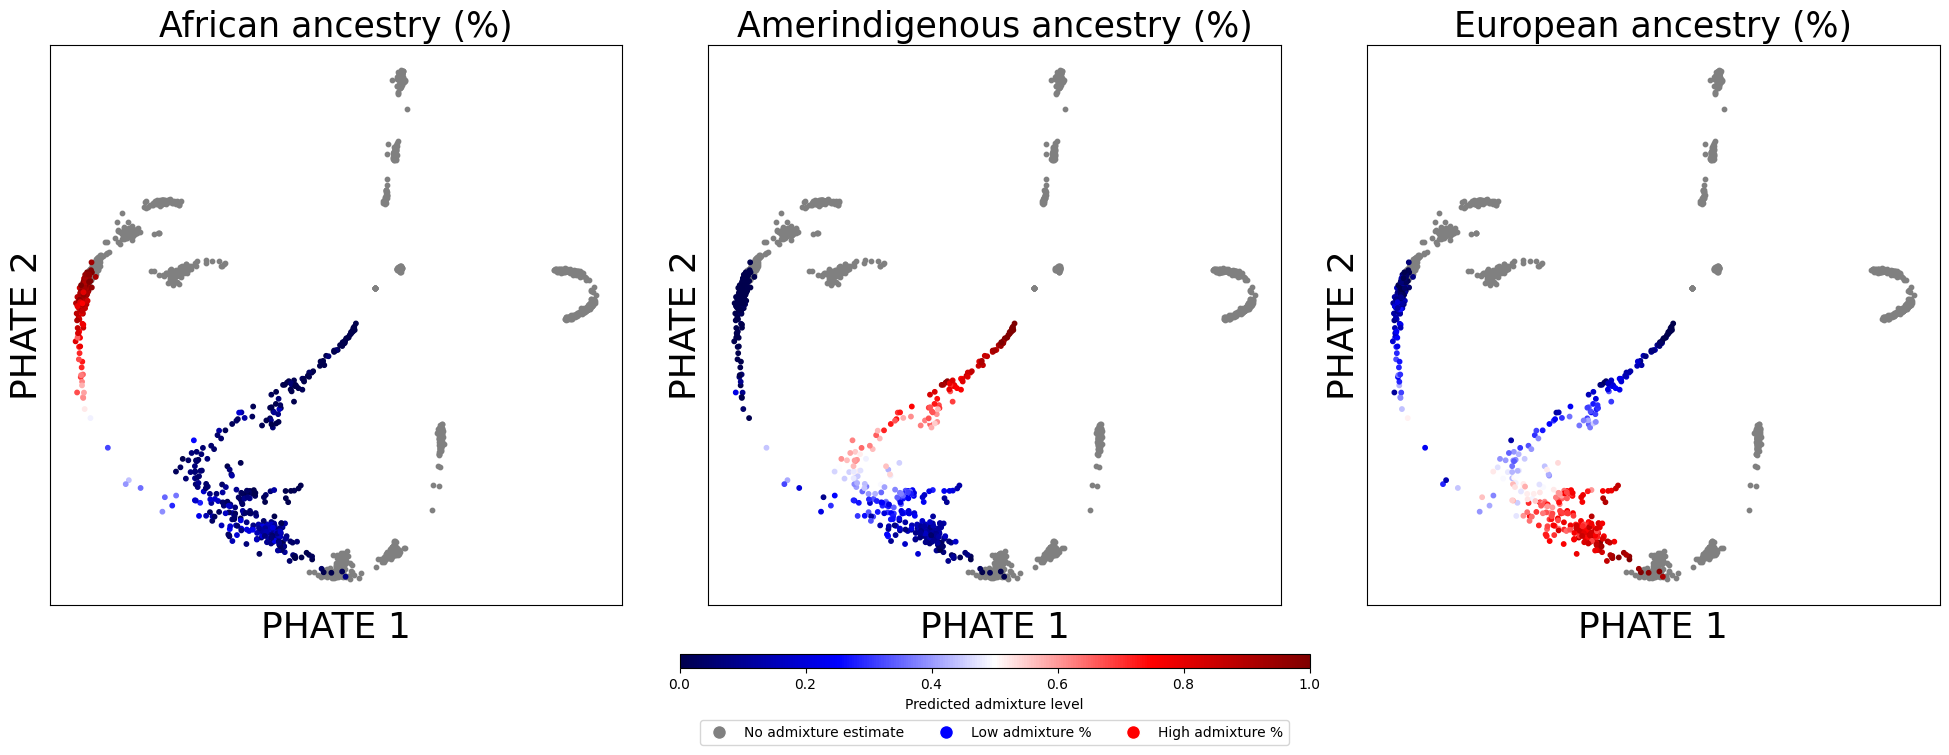

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(21, 7), gridspec_kw={'wspace': 0.15})

scatter_no_admix, scatter_admix, legend_elements = plot_admixture(phate_embedding, admix_ratios, ax, label_prefix='PHATE ')

for i, score_name in enumerate(admix_ratios.columns):
    ax[i].set_title(score_name, fontsize=25)

# Add colorbar
cbar_ax = fig.add_axes([0.35, 0.06, 0.3, 0.02])  # Adjust these values as needed for position and size
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.seismic), cax=cbar_ax, orientation='horizontal', fraction=0.02)
cbar.set_label('Predicted admixture level')

# Add custom legend
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.06), ncol=3)

# Manually adjust the layout
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.15, hspace=0.3, wspace=0.3)

plt.show()

Unlike t-SNE, we can see the admixture structure as a trajectory in the PHATE embeddings. Unlike with PCA, we do not have points appearing inappropriately in these trajectories.

We showed earlier that we could not easily use PCA to identify the subpopulation of ITU. We show now that the PHATE embedding makes identifying the subpopulation an easy task.

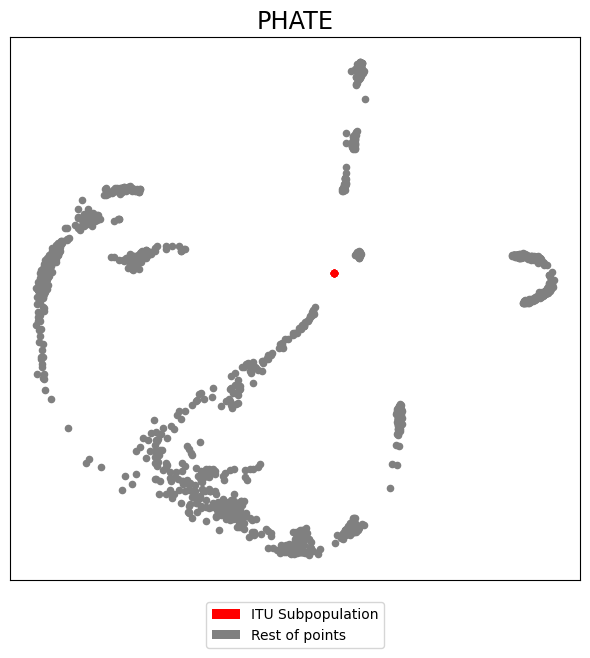

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

scprep.plot.scatter2d(phate_embedding[~ITU_subpopulation_idxs], s=20, ax=ax,
                      color='grey', xticks=False, yticks=False, legend=False,
                      title='PHATE', fontsize=10)

scprep.plot.scatter2d(phate_embedding[ITU_subpopulation_idxs], s=20, ax=ax,
                      color='red', xticks=False, yticks=False, legend=False,
                      title='PHATE', fontsize=10)

legend_elements = [Patch(facecolor='red', label='ITU Subpopulation'),
                   Patch(facecolor='grey', label='Rest of points')]

fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.1))
plt.tight_layout()

## PHATE Stratifies Populations At Least as Well as t-SNE and PCA

Finally, we show that PHATE can be used for population stratification at least as well as t-SNE or PCA.

Following Diaz [<a href="#DiazPapkovich2023">9</a>], we performed clustering on multidimensional dimensional PHATE embeddings using Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN). We then compare the confusion matrices to see how well it performs versus t-SNE and PCA.

To speed up computations, we only look at 3D embeddings.

In [ ]:
# Long step
phate_operator_3d = phate.PHATE(random_state=42,
                                n_components=3,
                                knn=5,
                                decay=60,
                                n_pca=None)
phate_emb_3d = phate_operator_3d.fit_transform(inputs.values)

tsne_op_3d = TSNE(n_components=3, perplexity=20, max_iter=1000, random_state=42)
tsne_emb_3d = tsne_op_3d.fit_transform(inputs.values)

Calculating PHATE...
  Running PHATE on 2322 observations and 100 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.59 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.63 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.26 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.39 seconds.
  Calculated landmark operator in 5.71 seconds.
  Calculating optimal t...
    Automatically selected t = 9
  Calculated optimal t in 5.12 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.76 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 48.74 seconds.
Calculated PHATE in 61.98 seconds.


We run HDBSCAN clustering on each. We set `min_points=60` because we know our smallest sampled population has around 60 points in it.

In [ ]:
def get_summary(clusterer):
    print('Number of clusters:', str(max(clusterer.labels_)+1))
    print('Number unassigned:', str(np.sum(clusterer.labels_ == -1)))
    print('ARI:', adjusted_rand_score(labels['population'], clusterer.labels_))

print('PHATE')
min_points = 60
clusterer_phate = sklearn.cluster.HDBSCAN(min_cluster_size=min_points)
clusterer_phate.fit(phate_emb_3d)
get_summary(clusterer_phate)

# t-SNE
print('t-SNE')
min_points = 60
clusterer_tsne = sklearn.cluster.HDBSCAN(min_cluster_size=min_points)
clusterer_tsne.fit(tsne_emb_3d)
get_summary(clusterer_tsne)

# PCA
print('PCA')
min_points = 60
clusterer_pca = sklearn.cluster.HDBSCAN(min_cluster_size=min_points)
clusterer_pca.fit(inputs.values[:,:3])
get_summary(clusterer_pca)

# PCA
print('PCA 100D')
min_points = 60
clusterer_pca_full = sklearn.cluster.HDBSCAN(min_cluster_size=min_points)
clusterer_pca_full.fit(inputs.values)
get_summary(clusterer_pca_full)

PHATE
Number of clusters: 15
Number unassigned: 263
ARI: 0.5813105747406804
t-SNE
Number of clusters: 10
Number unassigned: 416
ARI: 0.34021237261656523
PCA
Number of clusters: 4
Number unassigned: 27
ARI: 0.21755571147219047
PCA 100D
Number of clusters: 5
Number unassigned: 351
ARI: 0.2630898842118029


The ARI is significantly higher for the PHATE embedding.

In [ ]:
def make_confusion_matrix(clusterer, ax):
    df = pd.DataFrame(columns=['HDBSCAN Cluster', 'Population'], index=inputs.index)
    df['HDBSCAN Cluster'] = clusterer.labels_
    df['Population'] = labels['population']

    # Filter out the -1 cluster (unclustered data)
    df = df[df['HDBSCAN Cluster'] != -1]
    # Create a cross-tabulation of clusters and populations
    crosstab = pd.crosstab(df['HDBSCAN Cluster'], df['Population'])
    # Convert counts to proportions
    proportions = crosstab.div(crosstab.sum(axis=1), axis=0)

    # Reorder the populations to match the clusters
    ordered_populations = proportions.idxmax().sort_values().index
    proportions = proportions[ordered_populations]


    heatmap = sns.heatmap(proportions, cmap='viridis', annot=False,linewidths=0.05, linecolor='purple', cbar_kws={'shrink': 0.8}, ax=ax)
    heatmap.invert_yaxis()
    ax.set_xlabel('Population')
    ax.set_ylabel('HDBSCAN Cluster')
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=12)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=12)

    # Adjust the color bar tick labels font size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=10)

We plotted a heatmap that illustrates the distribution of various populations across clusters identified by the HDBSCAN. Each cell in the heatmap corresponds to the proportion of a specific population within a particular cluster, with higher proportions indicated by brighter colors. When comparing the methods, the heatmap for PHATE shows  more clusters containing all and only individuals of a single population (although all methods have clusters containing two or more populations).

This figure demonstrates that the PHATE embedding retains sufficient information to be used for stratification.

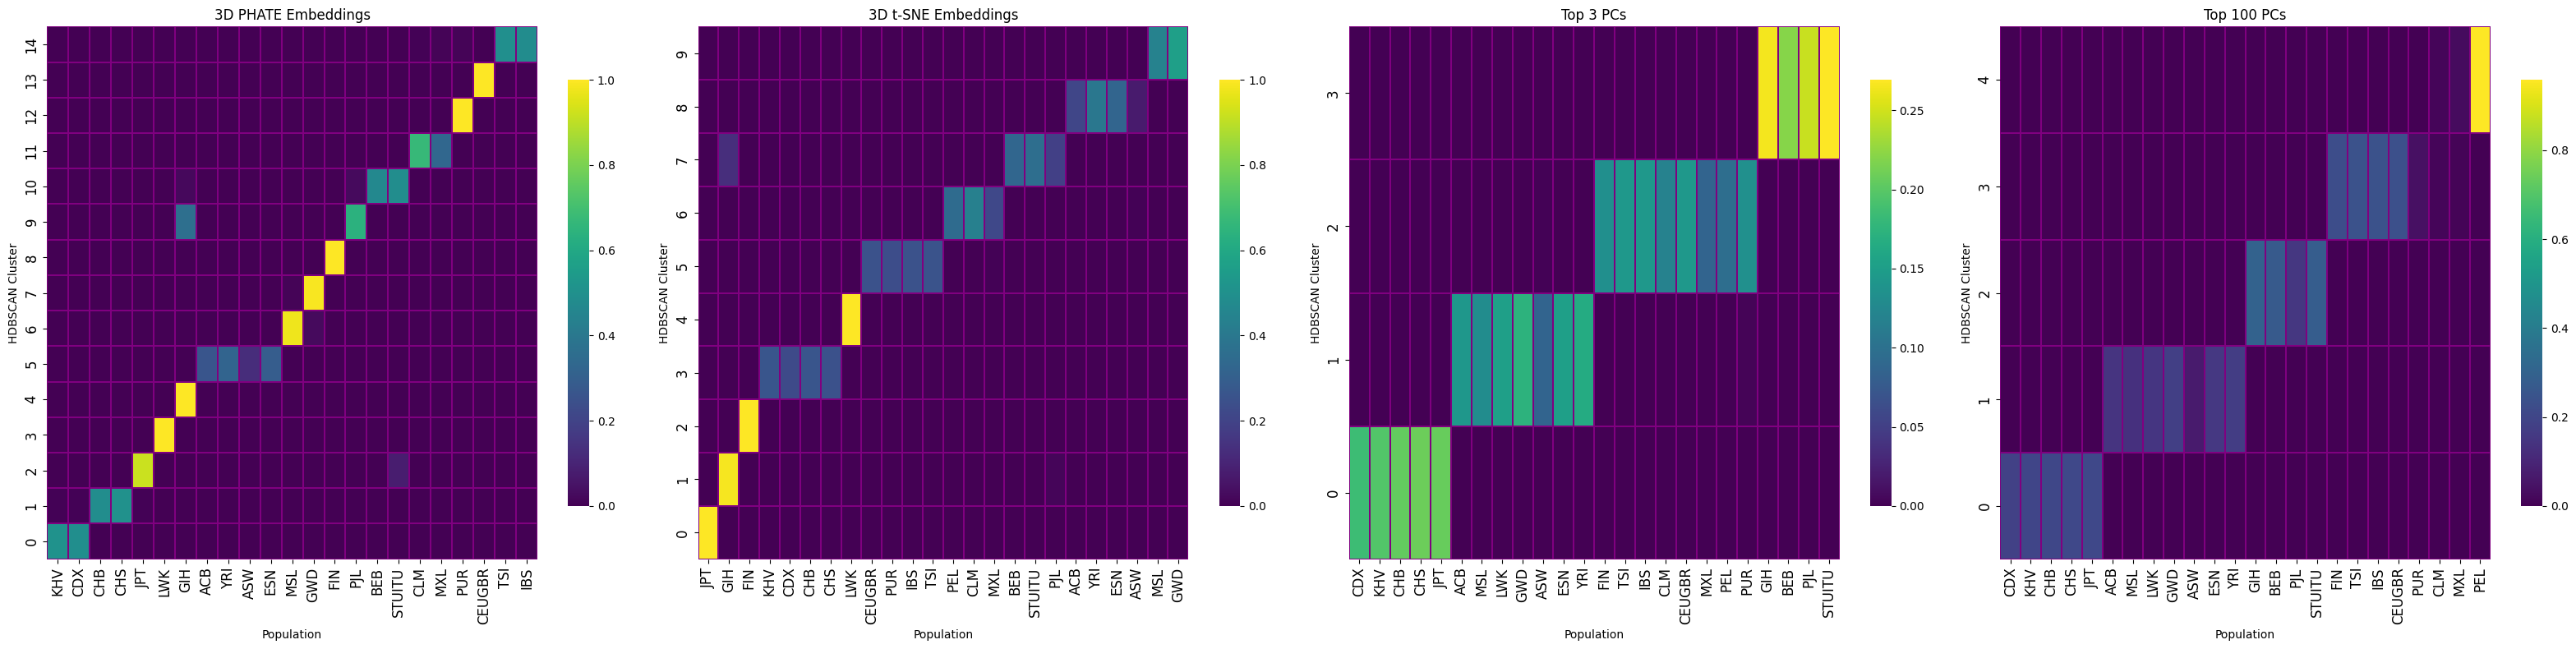

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(32, 8))
make_confusion_matrix(clusterer_phate, ax=ax[0])
make_confusion_matrix(clusterer_tsne, ax=ax[1])
make_confusion_matrix(clusterer_pca, ax=ax[2])
make_confusion_matrix(clusterer_pca_full, ax=ax[3])

_ = ax[0].set_title('3D PHATE Embeddings')
_ = ax[1].set_title('3D t-SNE Embeddings')
_ = ax[2].set_title('Top 3 PCs')
_ = ax[3].set_title('Top 100 PCs')
plt.tight_layout()

# Conclusion

By embedding high-dimensional genetic data into low-dimensional spaces, PHATE facilitates the visualization and interpretation of genetic diversity and population structure.
The resulting embeddings can distinguish between different populations while also showing the continuous variation between them, offering insights that are both scientifically meaningful and less likely to be misleading to the public.

This work promotes a continuous view of ancestry and moves away from continental ancestry categories, with the potential to help the field adopt representations of genetic data that better reflect human evolutionary history.

# References

1. <a name="phate"></a> Moon, K.R., van Dijk, D., Wang, Z. et al. Visualizing structure and transitions in high-dimensional biological data. Nat Biotechnol 37, 1482–1492 (2019). https://doi.org/10.1038/s41587-019-0336-3

2. <a name="tsne"></a> van der Maaten, Laurens, and Geoffrey Hinton. "Visualizing Data using t-SNE." Journal of Machine Learning Research 9 (2008): 2579-2605. http://jmlr.org/papers/v9/vandermaaten08a.html

3. <a name="2024AllofUs"></a> Bick, Alexander G. et al. Genomic data in the All of Us Research Program. Nature 627, 340–346 (2024). https://doi.org/10.1038/s41586-023-06957-x

4. <a name="admixture"></a> Alexander, D. H., Novembre, J., Lange, K. Fast model-based estimation of ancestry in unrelated individuals. Genome Research 19, 1655-1664. (2009). http://dx.doi.org/10.1101/gr.094052.109

5. <a name="Patterson2006"></a> Patterson, Nick, Price, Alkes L., and Reich, David. Population Structure and Eigenanalysis. PLoS Genetics 2, e190 (2006). https://doi.org/10.1371/journal.pgen.0020190

6. <a name="Novembre2008"></a> Novembre, John, Johnson, Toby, Bryc, Katarzyna, Kutalik, Zoltán, Boyko, Adam R., Auton, Adam, Indap, Amit, King, Karen S., Bergmann, Sven, Nelson, Matthew R., Stephens, Matthew, and Bustamante, Carlos D. Genes mirror geography within Europe. Nature 456, 98-101 (2008). https://doi.org/10.1038/nature07331

7. <a name="mcinnes2018umap"></a> McInnes, L., Healy, J., et al. UMAP: Uniform Manifold Approximation and Projection. Journal of Open Source Software 3, 861 (2018). https://doi.org/10.21105/joss.00861

8. <a name="DiazPapkovich2020"></a> Diaz-Papkovich, Alex, Anderson-Trocmé, Luke, and Gravel, Simon. A review of UMAP in population genetics. Journal of Human Genetics 66, 85-91 (2020). https://doi.org/10.1038/s10038-020-00851-4

9. <a name="DiazPapkovich2023"></a> Diaz-Papkovich, Alex, Zabad, Shadi, Ben-Eghan, Chief, Anderson-Trocmé, Luke, Femerling, Georgette, Nathan, Vikram, Patel, Jenisha, and Gravel, Simon. Topological stratification of continuous genetic variation in large biobanks. Cold Spring Harbor Laboratory (2023). https://doi.org/10.1101/2023.07.06.548007

10. <a name="Sakaue2020"></a> Sakaue, Saori, Hirata, Jun, Kanai, Masahiro, Suzuki, Ken, Akiyama, Masato, Lai Too, Chun, Arayssi, Thurayya, Hammoudeh, Mohammed, Al Emadi, Samar, Masri, Basel K., Halabi, Hussein, Badsha, Humeira, Uthman, Imad W., Saxena, Richa, Padyukov, Leonid, Hirata, Makoto, Matsuda, Koichi, Murakami, Yoshinori, Kamatani, Yoichiro, Okada, Yukinori. Dimensionality reduction reveals fine-scale structure in the Japanese population with consequences for polygenic risk prediction. Nature Communications 11, 1-11 (2020). https://doi.org/10.1038/s41467-020-15194-z

11. <a name="wattenberg2016how"></a> Wattenberg, Martin, Viégas, Fernanda, and Johnson, Ian. How to Use t-SNE Effectively. Distill (2016). https://doi.org/10.23915/distill.00002

12. <a name="1000G"></a> The 1000 Genomes Project Consortium. A global reference for human genetic variation. Nature 526, 68-74 (2015). https://doi.org/10.1038/nature15393

13. <a name="Battey2021"></a> Battey, C. J., Coffing, Gabrielle C., and Kern, Andrew D. Visualizing population structure with variational autoencoders. G3: Genes|Genomes|Genetics 11, (2021). https://doi.org/10.1093/g3journal/jkaa036

14. <a name="Sengupta2016"></a> Sengupta, Dhriti, Choudhury, Ananyo, Basu, Analabha, and Ramsay, Michèle. Population Stratification and Underrepresentation of Indian Subcontinent Genetic Diversity in the 1000 Genomes Project Dataset. Genome Biology and Evolution 8, 3460–3470 (2016). https://doi.org/10.1093/gbe/evw244